<a href="https://colab.research.google.com/github/anisaafn/2025_Visi-Komputer_TI-2B/blob/master/Jobsheet_3_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)
Bayangkan Anda memiliki ribuan gambar hitam-putih sederhana yang masing-masing berisi satu lingkaran dengan ukuran berbeda. Dari gambar-gambar itu, bisakah komputer menebak berapa besar radius lingkarannya hanya dengan melihat citra tersebut?

Di praktikum ini, kita akan membuat dataset sendiri menggunakan Python. Setiap gambar dihasilkan secara acak dengan lingkaran berwarna putih di atas latar hitam. Labelnya? Nilai radius lingkaran itu sendiri! Inilah pintu masuk untuk memahami konsep dasar regresi gambar: kita akan melatih model Convolutional Neural Network (CNN) kecil agar mampu memetakan gambar → angka.

Setelah dataset selesai dibuat, model CNN akan dibangun menggunakan Keras. Jaringan ini akan belajar dari ribuan contoh yang kita hasilkan, dan Anda akan melihat bagaimana loss berkurang di setiap epoch. Pada akhir latihan, grafik loss vs epoch akan menunjukkan apakah model Anda sudah “mengerti” bentuk lingkaran.
Menariknya, Anda dapat langsung melihat hasil prediksi dengan membuat plot antara radius sebenarnya dan hasil prediksi. Jika garis hasil hampir menyentuh garis diagonal, artinya model sudah cukup baik dalam melakukan regresi.
Tujuan belajar:
•	Memahami alur penuh regresi gambar tanpa dataset eksternal.
•	Melatih CNN sederhana untuk prediksi nilai kontinu.
•	Mengevaluasi performa dengan MAE, RMSE, dan R².


1)	Setup & Generator Dataset

Kita akan membuat dataset citra 64×64 berisi satu lingkaran putih di latar hitam. Tiap gambar punya radius dan titik pusat acak.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    # radius acak
    r = np.random.randint(min_r, max_r + 1)

    # buat canvas hitam
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    # posisi pusat lingkaran acak
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)

    # gambar lingkaran putih terisi
    cv2.circle(img, (cx, cy), r, (255,), -1)

    # normalisasi ke [0,1]
    img = (img / 255.0).astype(np.float32)

    # ubah ke 3-channel agar kompatibel dengan CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)

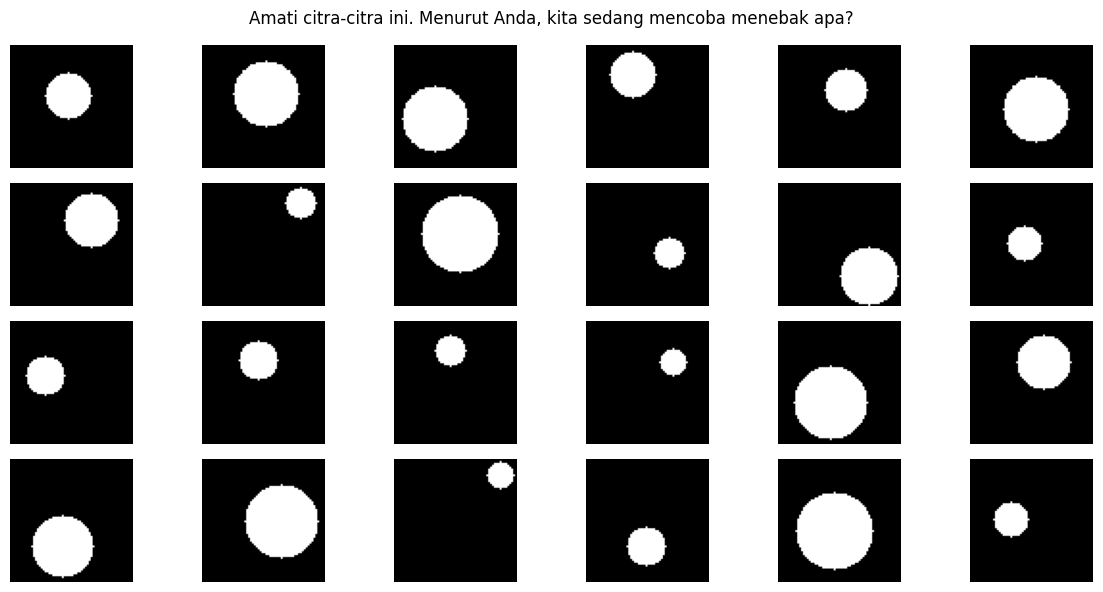

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]

# Pisahkan komponen hasil
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=12)
plt.tight_layout()
plt.show()


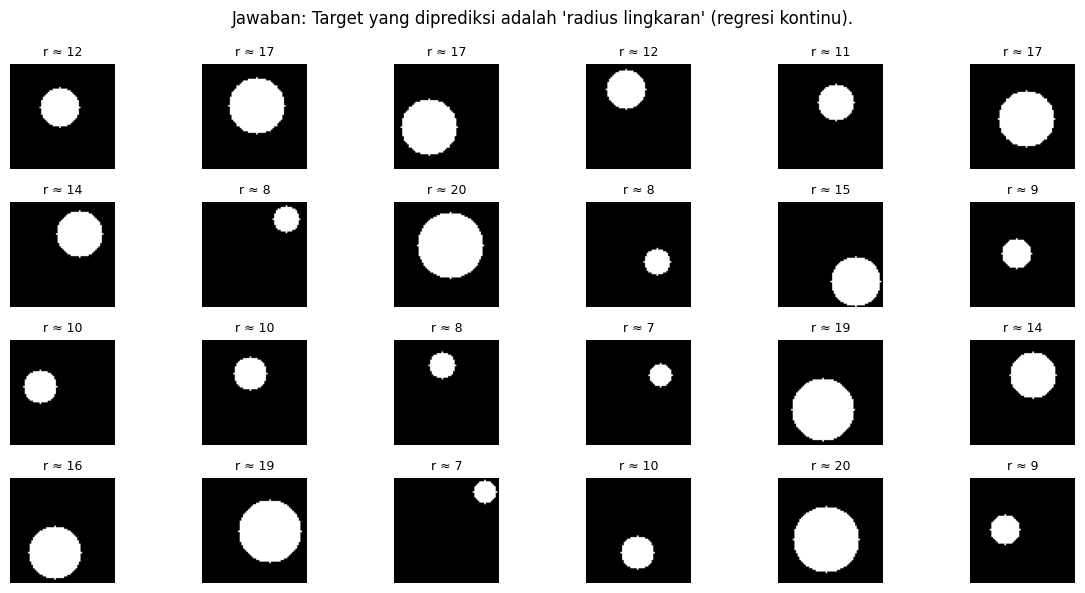

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}", fontsize=9)
    plt.axis('off')

plt.suptitle(
    "Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).",
    fontsize=12
)
plt.tight_layout()
plt.show()

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Bagi dataset menjadi train dan test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training model
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
MAE = 0.956 | RMSE = 1.168 | R² = 0.935


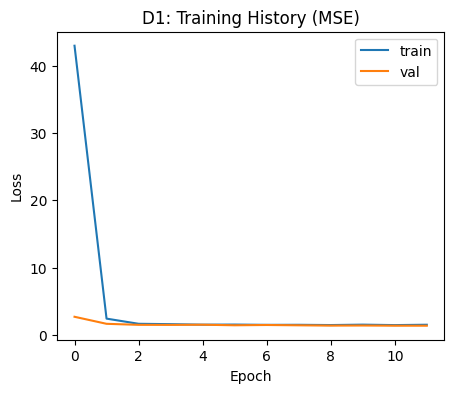

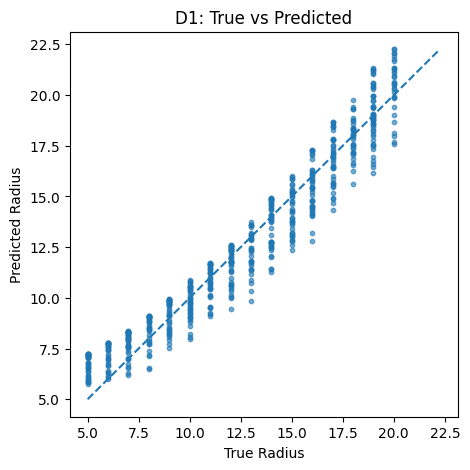

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

5)	Tantangan Mini (Opsional untuk Mahasiswa)
•	Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
•	Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
•	Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus; metrik evaluasi apa yang cocok?


## Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)
Pernahkah Anda memperhatikan wajah seseorang dan mencoba menebak usianya? Mungkin dari garis senyum, bentuk rahang, atau tekstur kulit. Nah, komputer juga bisa melakukan hal yang sama — dengan belajar dari ribuan contoh wajah berlabel umur. Di praktikum ini, kita akan membuat sistem sederhana yang mampu memperkirakan umur seseorang dari fotonya menggunakan teknik regresi gambar.

Dataset yang digunakan bernama UTKFace, berisi ribuan foto wajah manusia dari berbagai usia, jenis kelamin, dan ras. Setiap foto memiliki nama file yang sudah menyimpan label umur. Contohnya:
11_0_0_20170110225327724.jpg.chip.jpg(5.92 kB)

Artinya, usia = 11 tahun, gender = laki-laki (0), ras = Asia (0). Namun kita hanya akan fokus pada nilai pertama (umur) sebagai target regresi.
Tujuan belajar:
•	Mengenal dataset wajah dan ekstraksi label dari nama file.

•	Menggunakan transfer learning pada model CNN.
•	Menerapkan regresi untuk masalah nyata (estimasi umur).


### Langkah 1 — Membuat Akun Kaggle dan Mengunduh kaggle.json
Agar dapat mengakses dataset publik Kaggle, mahasiswa perlu membuat akun terlebih dahulu.
Ikuti langkah berikut:
1.	Buka situs https://www.kaggle.com
2.	Daftar menggunakan email Google atau GitHub.
3.	Setelah login, klik profil di kanan atas → pilih “Account”.
4.	Gulir ke bawah ke bagian API → klik “Create New API Token”.
5.	File bernama kaggle.json akan otomatis terunduh ke komputer Anda.
File ini berisi API key pribadi agar Colab bisa mengakses dataset Kaggle Anda.
Simpan file kaggle.json dengan baik (jangan dibagikan ke orang lain).


Langkah 2 — Mengunggah kaggle.json ke Colab

In [22]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [26]:
# Buat folder untuk menyimpan dataset
!mkdir -p /content/dataset

# Unduh dataset UTKFace dari Kaggle
!kaggle datasets download -d jangedoo/utkface-new -p /content/dataset

# Ekstrak hasil unduhan
!unzip -q /content/dataset/utkface-new.zip -d /content/utk

print("✅ Dataset UTKFace berhasil diunduh dan diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 90% 298M/331M [00:03<00:00, 88.3MB/s]
100% 331M/331M [00:03<00:00, 114MB/s] 
✅ Dataset UTKFace berhasil diunduh dan diekstrak.


Setelah diunggah, jalankan sel berikut untuk menyiapkan koneksi Kaggle:

In [23]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle


In [24]:
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

unzip:  cannot find or open /content/utkface-new.zip, /content/utkface-new.zip.zip or /content/utkface-new.zip.ZIP.
✅ Dataset UTKFace berhasil diekstrak.


Langkah 4 — Menampilkan Contoh Gambar Dataset

Sebelum	melatih	model,	mari	lihat	langsung	seperti	apa	data	wajahnya. Ini membantu mahasiswa memahami apa masalah yang sedang diselesaikan.


Total gambar ditemukan: 23708


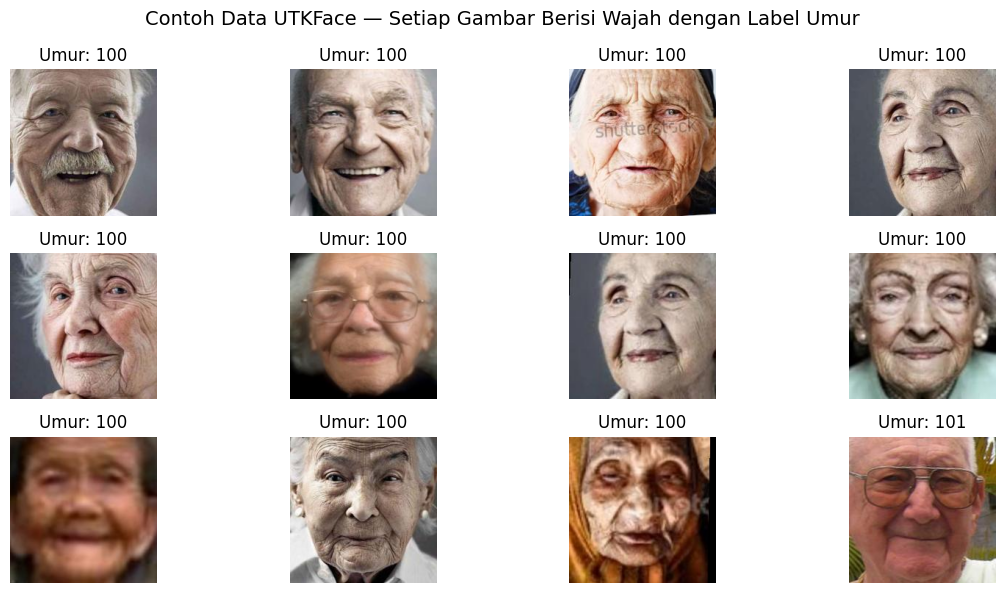

In [27]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]): # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

•◆. Hasil visualisasi: Mahasiswa akan melihat wajah-wajah dari berbagai usia (anak, remaja, dewasa, hingga lansia). Inilah masalah regresi yang akan kita selesaikan:
“Dari citra wajah, perkirakan umur seseorang dalam satuan tahun.”

Langkah 5 — Siapkan Dataset untuk Model
Berikut langkah singkat memuat gambar ke TensorFlow Dataset.

In [29]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# --- Fungsi bantu untuk mengambil label umur dari nama file ---
def parse_age_from_name(fp):
    # Nama file formatnya misal: "25_1_0_20170109150557335.jpg"
    return int(os.path.basename(fp).split('_')[0])

# --- Ambil daftar file dari dataset ---
files = tf.io.gfile.glob("/content/utk/UTKFace/*.jpg")  # pastikan path sesuai folder hasil unzip
print(f"Total gambar ditemukan: {len(files)}")

# --- Ambil label umur dari nama file ---
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

# --- Pisahkan dataset menjadi train dan test ---
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

# --- Fungsi preprocessing gambar ---
IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

# --- Buat dataset TensorFlow ---
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_files, y_train))
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_files, y_test))
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅ Dataset siap dilatih.")

Total gambar ditemukan: 23708
✅ Dataset siap dilatih.


Langkah 6 — Membangun Model dengan Transfer Learning
Setelah memahami seperti apa data wajah di UTKFace, kita kini akan melangkah ke tahap inti:
membangun model deep learning untuk memprediksi umur dari foto.
Karena wajah memiliki pola kompleks — mata, kulit, ekspresi, pencahayaan — kita tidak akan melatih CNN dari nol.
Sebaliknya, kita akan menggunakan pendekatan transfer learning: memanfaatkan jaringan yang sudah belajar banyak tentang dunia visual (dari ImageNet), lalu menyesuaikannya sedikit untuk tugas regresi umur.
Model dasar yang kita gunakan adalah MobileNetV2 — ringan, cepat, dan cukup akurat untuk dataset wajah berukuran menengah seperti UTKFace.


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- Gunakan GPU jika tersedia ---
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# --- Buat arsitektur model ---
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

# Tahap awal: freeze backbone (feature extractor)
base_model.trainable = False

# --- Tambahkan head regresi ---
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# --- Kompilasi model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

# --- Ringkasan model ---
model.summary()

Hardware: CPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Penjelasan singkat arsitektur:
•	MobileNetV2 sudah “terlatih melihat dunia”, kita hanya menyesuaikan layer akhir untuk memetakan wajah → umur.
•	GlobalAveragePooling2D mengubah fitur spasial menjadi vektor global.
•	Dropout membantu mencegah overfitting.
•	Output 1 neuron: prediksi umur dalam skala kontinu.

Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Tahap pertama ini adalah pemanasan.
Kita hanya melatih bagian head regresi, sementara backbone-nya tetap beku. Tujuannya agar bagian atas bisa “belajar membaca” fitur wajah tanpa mengganggu pengetahuan umum MobileNetV2.

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - loss: 360.3333 - mae: 14.1516 - val_loss: 151.4516 - val_mae: 9.2389 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - loss: 156.5679 - mae: 9.3642 - val_loss: 135.5652 - val_mae: 8.6153 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - loss: 145.8460 - mae: 8.9366 - val_loss: 130.5465 - val_mae: 8.4158 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - loss: 141.0194 - mae: 8.7518 - val_loss: 127.5113 - val_mae: 8.2903 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - loss: 137.8524 - mae: 8.6572 - val_loss: 125.8930 - val_mae: 8.2619 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - loss: 135.4892 - mae: 8.5791 - val_loss: 124.8428 - val_mae: 8.2058 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - loss: 134.0878 - mae: 8.5313 - val_loss: 124.7892 - val_mae: 8

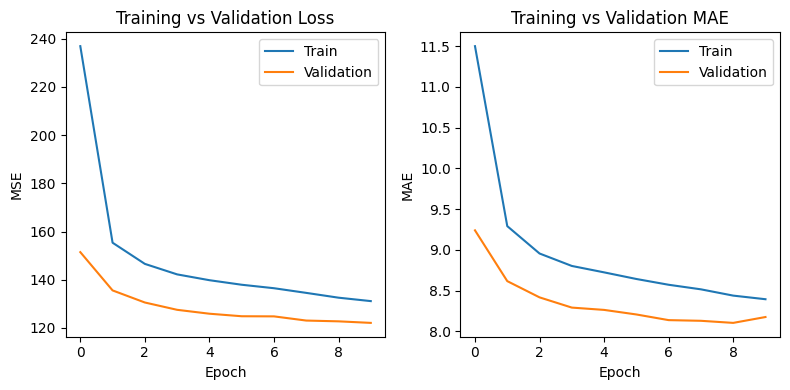

In [31]:
# --- Callback untuk pelatihan yang lebih stabil ---
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

# --- Proses pelatihan model ---
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# --- Visualisasi perubahan loss dan MAE selama pelatihan ---
plt.figure(figsize=(8, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

Ç Interpretasi:

•	Jika val_loss menurun dan stabil, model mulai memahami hubungan antara fitur wajah dan umur.
•	Jika val_loss naik terus, berarti model mulai overfitting — butuh dropout atau augmentasi tambahan.


Langkah 8 — Fine-tuning Backbone (Tahap 2)

Setelah head regresi beradaptasi, kita bisa membuka sebagian lapisan MobileNetV2 (fine- tuning) agar fitur internal menyesuaikan karakter wajah manusia.


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - loss: 180.9068 - mae: 9.8630 - val_loss: 121.8186 - val_mae: 8.2081 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - loss: 77.9220 - mae: 6.5664 - val_loss: 106.7859 - val_mae: 7.6402 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - loss: 50.8369 - mae: 5.3579 - val_loss: 110.8141 - val_mae: 7.4491 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - loss: 36.5559 - mae: 4.5707 - val_loss: 102.1398 - val_mae: 7.1262 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - loss: 30.3240 - mae: 4.1530 - val_loss: 91.8320 - val_mae: 6.9172 - learning_rate: 1.0000e-04


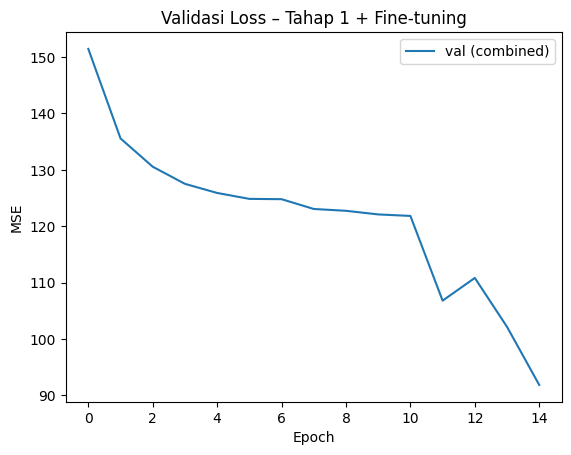

In [32]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Bekukan sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae']
)

# Fine-tuning model
history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

Setelah model selesai, mari kita ukur seberapa dekat prediksi dengan kenyataan.


MAE  = 6.92 tahun
RMSE = 9.58 tahun
R²   = 0.765


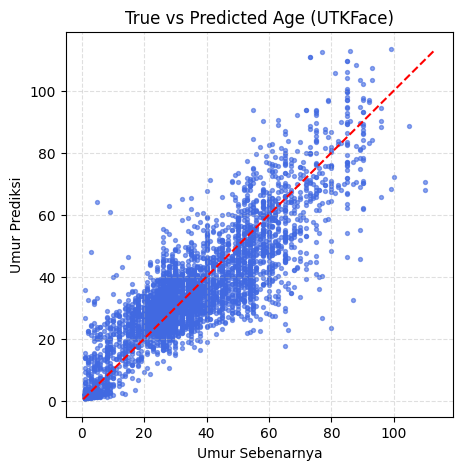

In [33]:
from math import sqrt

# Prediksi nilai pada dataset uji
y_pred = np.concatenate([
    model.predict(batch[0], verbose=0).ravel()
    for batch in test_ds
])

# Evaluasi performa model
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)

# Tampilkan hasil evaluasi
print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')

lims = [
    min(y_test.min(), y_pred.min()),
    max(y_test.max(), y_pred.max())
]
plt.plot(lims, lims, '--', color='red')

plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

’" ´ Interpretasi hasil:

•	Semakin rapat titik ke garis merah → semakin akurat prediksi.
•	Nilai R² mendekati 1 menunjukkan model menjelaskan variasi data dengan baik.
•	MAE kecil → rata-rata selisih umur prediksi dengan kenyataan kecil (mis. ±3 tahun).


Langkah 10 — Melihat Contoh Prediksi Nyata
Mari lihat beberapa foto wajah berikut:
Berapa umur sebenarnya, dan berapa yang diprediksi model?


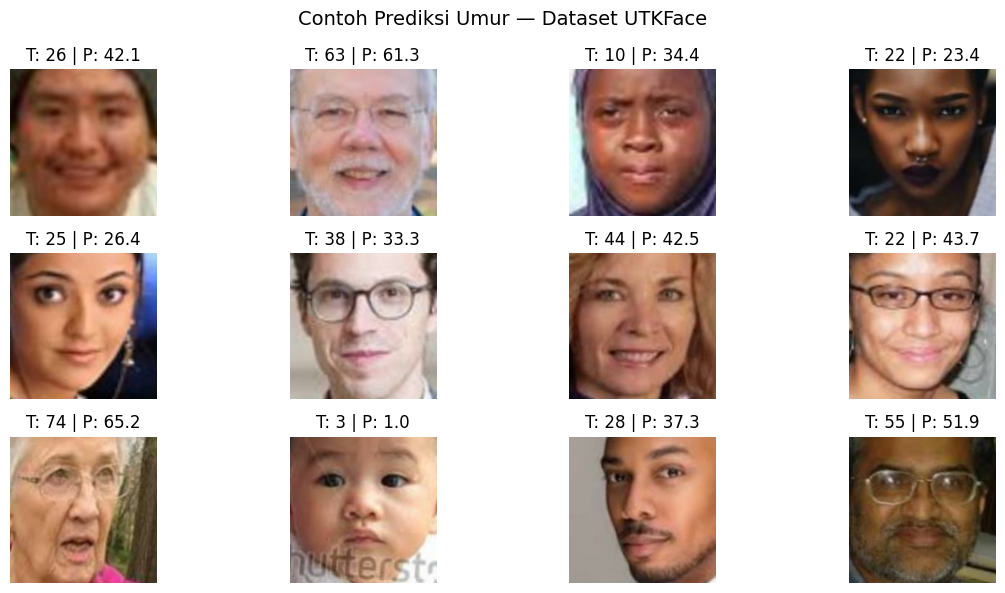

In [34]:
import random

# Ambil 12 sampel acak dari file uji
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    # Baca dan pra-proses gambar
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    # Ambil umur sebenarnya dari nama file
    true_age = int(os.path.basename(path).split('_')[0])

    # Prediksi umur menggunakan model
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    # Tampilkan gambar dan hasil prediksi
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T: {true_age} | P: {pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

Mahasiswa dapat mengamati bahwa prediksi cenderung akurat untuk usia dewasa, namun bisa sedikit meleset untuk anak kecil atau lanjut usia — ini membuka diskusi tentang bias dataset dan distribusi label.
Tantangan Mini (Opsional)
1.	Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2.	Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3.	Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4.	Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?


Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto
Bayangkan Anda membuka media sosial dan melihat dua foto hewan:
•	seekor anak anjing dengan mata besar yang menatap kamera,
•	seekor kucing yang sedang tidur di ruangan gelap.
Foto mana yang lebih menarik perhatian? Nah, para peneliti di PetFinder.my melakukan eksperimen serupa — mereka meminta ribuan orang untuk menilai seberapa menarik foto hewan peliharaan, dan setiap foto diberi skor antara 0–100 yang disebut Pawpularity Score.

Dalam praktikum ini, mahasiswa akan membangun sistem visi komputer yang dapat memperkirakan  skor  kepopuleran  hewan  peliharaan  dari  fotonya. Tugas ini adalah contoh nyata dari image regression di bidang computational aesthetics — mengajarkan mesin untuk memahami “daya tarik visual”.
"´ ’◎● Tujuan Praktikum
•	Memahami regresi gambar dengan target kontinu (0–100).
•	Mengenal dataset dunia nyata: PetFinder.my Pawpularity.
•	Melatih model EfficientNetB0 dengan transfer learning.
•	Mengevaluasi hasil dengan MAE, RMSE, R² dan visualisasi True vs Predicted.



Langkah 1 — Menyiapkan Kaggle API

Dataset ini tersedia di kompetisi Kaggle: PetFinder.my Pawpularity Contest. Cara Membuat Akun dan Mendapatkan kaggle.json

1.	Buka situs https://www.kaggle.com

2.	Login dengan akun Google.
3.	Klik profil → Account → gulir ke bawah ke bagian API.
4.	Klik Create New API Token.
File kaggle.json akan otomatis terunduh.
5.	Unggah file tersebut ke Colab dengan:

In [35]:
from google.colab import files
import os, shutil

# Upload file kaggle.json dari komputer
files.upload()  # Pilih kaggle.json

# Cek dan siapkan konfigurasi Kaggle API
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    # Instal library Kaggle
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("⚠️ File kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


Langkah 2 — Mengunduh dan Mengekstrak Dataset
sebelum Anda dapat mengunduh datasetnya, Anda harus mengikuti kompetisinya terlebih dahulu. Buka https://www.kaggle.com/competitions/petfinder-pawpularity-score/data kemudian join.


In [36]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q

# Ekstrak file ZIP hasil unduhan
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw

print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


Struktur folder:

/content/paw/train/ → berisi ribuan foto hewan (.jpg)
/content/paw/train.csv → berisi skor Pawpularity setiap foto



Langkah 3 — Melihat Contoh Data

Sebelum  melatih  model,  mari  kita  melihat  seperti  apa  bentuk  datanya. Kita akan memuat file train.csv dan menampilkan beberapa foto hewan dengan skor Pawpularity-nya.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

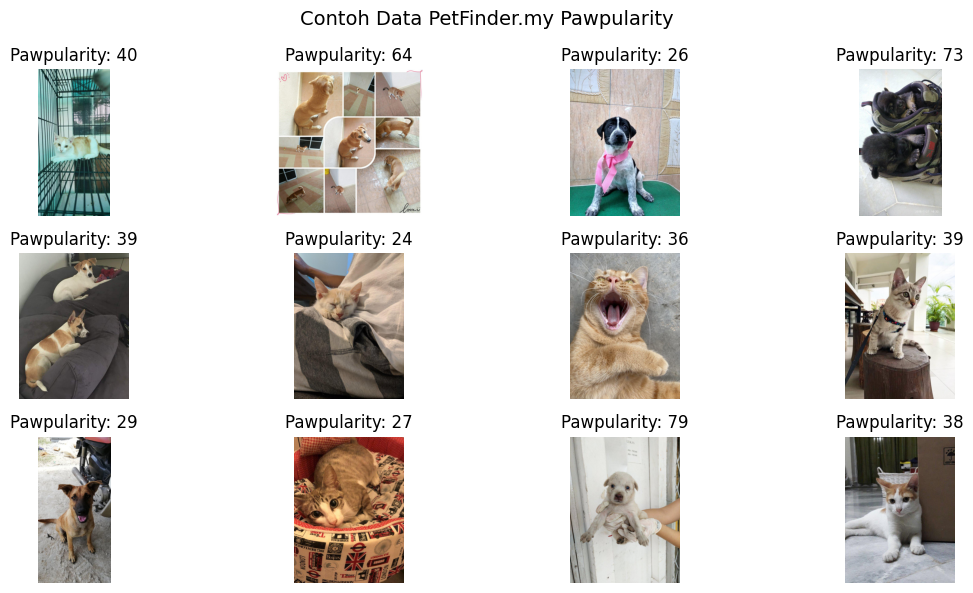

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")

print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Langkah 4 — Persiapan Dataset
Sebelum memulai pelatihan, data perlu disiapkan dalam format yang bisa diproses oleh TensorFlow.
Kita akan membagi data menjadi dua bagian:
•	Train set (80%) → untuk melatih model.
•	Validation set (20%) → untuk menguji kemampuan generalisasi.


In [38]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

# Bagi dataset menjadi data latih dan validasi (80:20)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Fungsi untuk memuat dan memproses gambar
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# Dataset training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(4096)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset validasi
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print(f"✅ Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

✅ Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


Langkah 4 — Membangun Model (EfficientNetB0)
Sekarang, bayangkan kita ingin membangun "otak digital" yang bisa menilai keindahan foto. Kita tidak mulai dari nol, karena sudah ada model yang sangat baik dalam mengenali gambar
— EfficientNetB0.
Model ini sebelumnya dilatih mengenali jutaan objek di ImageNet, dan kini kita hanya perlu “mengajarinya” hal baru: menilai daya tarik foto hewan berdasarkan skor 0–100.
Kita akan membekukan bagian awal model (agar pengetahuan dasar visual tidak hilang) dan menambahkan beberapa lapisan baru di atasnya untuk tugas regresi.


In [39]:
from tensorflow.keras import layers, models

# Gunakan EfficientNetB0 sebagai base model (tanpa top layer)
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # Freeze sementara (tidak dilatih pada tahap awal)

# Bangun model
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Tampilkan ringkasan model
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

C Penjelasan:
•	GlobalAveragePooling2D mengubah citra menjadi vektor fitur.
•	Dropout(0.3) membantu mencegah model menghafal.
•	Layer terakhir (Dense(1)) memproduksi skor pawpularity secara kontinu.


Langkah 5 — Melatih Model
Sekarang saatnya memberi “pengalaman belajar” pada model.
Setiap gambar akan dilihat, diproses, dan dibandingkan dengan skor sebenarnya. Kesalahan (error) digunakan untuk memperbaiki bobot jaringan agar prediksi semakin mendekati nilai asli.

In [ ]:
# Callback untuk early stopping dan pengaturan learning rate adaptif
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5
    )
]

# Latih model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

Epoch 1/10
 46/124 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step - loss: 1152.5424 - mae: 26.6575